### License
> Copyright 2023 Anna Maria Krol
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>     http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
# python 3.9.18 kernel with Qiskit
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer import AerSimulator
# for use with older versions of Qiskit/Qiskit Aer
from qiskit import Aer
from qiskit import transpile, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT, MCXGate
import random as random

from mcphase_cnx_noancillas import cnx
from operator_definitions import *
from count_valid_states import validate_state
from helper_functions import combine_registers, grayCode

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-afh71ysj because the default path (/data/localhome/amkrol/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Calculating the value of the buffer per day

See QISS_1day for explanations for the functions used. (This function is unchanged from QISS_moredays.ipynb)

In [2]:
def bufferfor1day(circuit, buffer_qubits, s1_qubits, s1_shifts, s2_qubits, s2_shifts, ancilla_qubits, condition_qubit, B_max, min_prec):
    # B_out = B_init + S1 - S2
    add(circuit, s1_shifts, buffer_qubits, s1_qubits)
    subtract(circuit, s2_shifts, buffer_qubits, s2_qubits)

    # MAX(0, B_out)
    circuit.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
    MAX0_B(circuit, buffer_qubits, ancilla_qubits)
    circuit.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

    # Condition c1: B_out <= B_max
    subtract(circuit, B_max+min_prec, buffer_qubits)

    circuit.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
    circuit.cnot(buffer_qubits[-1], condition_qubit)
    circuit.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

    # uncompute
    add(circuit, B_max+min_prec, buffer_qubits)

# Making the oracle

Same as before, but now we do *cost* and buffer calculations for each day and calculate the (negated) output volume for all the days.

Each day has its own subset of the shop qubits, ancilla qubits and condition qubits, all days use the same set of buffer and cost qubits.


This is defined as a separate function to make it easier to apply the inverse oracle.

In [3]:
def oracle(shop1_qubits, shop2_qubits, cost_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, number_of_days, B_init, B_max, shifts_s1, shifts_s2, costs_s1, costs_s2, C_up, V_target, delta, minimum_precision, num_shop_qubits, num_buffer_qubits):
    shftsched_oracle = QuantumCircuit(shop1_qubits, shop2_qubits, cost_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, name="Oracle")
    shftsched_oracle.h(cost_qubits)
    shftsched_oracle.h(buffer_qubits)

    # Initial buffer content
    add(shftsched_oracle, B_init,buffer_qubits)

    # Calculate the buffer content (and condition) for each day
    for day in range(number_of_days):
            bufferfor1day(shftsched_oracle, buffer_qubits, shop1_qubits[day*num_shop_qubits:(day+1)*num_shop_qubits], shifts_s1, shop2_qubits[day*num_shop_qubits:(day+1)*num_shop_qubits], shifts_s2, max_ancilla[day*num_buffer_qubits:(day+1)*num_buffer_qubits], condition_qubits[day], B_max, minimum_precision)

    # Calculate (-)output volume: -V_out = B_final - S1 - B_init
    for day in range(number_of_days):
        subtract(shftsched_oracle, shifts_s1, buffer_qubits, shop1_qubits[day*num_shop_qubits:(day+1)*num_shop_qubits])
    subtract(shftsched_oracle, B_init, buffer_qubits)

    # condition c2: V_out >= V_low
    add(shftsched_oracle, V_target-delta-minimum_precision, buffer_qubits)
    shftsched_oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
    shftsched_oracle.cnot(buffer_qubits[-1], condition_qubits[-3])
    shftsched_oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

    # condition c3: V_out <= V_up 
    add(shftsched_oracle, 2*delta + minimum_precision, buffer_qubits) 
    shftsched_oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
    shftsched_oracle.x(condition_qubits[-2])
    shftsched_oracle.cnot(buffer_qubits[-1], condition_qubits[-2])

    # Add the cost for both shops for each day 
    for day in range(number_of_days):
        add(shftsched_oracle, costs_s1, cost_qubits, shop1_qubits[day*num_shop_qubits:(day+1)*num_shop_qubits])
        add(shftsched_oracle, costs_s2, cost_qubits, shop2_qubits[day*num_shop_qubits:(day+1)*num_shop_qubits])
    
    # condition c4: C_out < C_up
    subtract(shftsched_oracle, C_up, cost_qubits)
    shftsched_oracle.append(QFT(cost_qubits.size, do_swaps=False, inverse=True), cost_qubits)
    shftsched_oracle.cnot(cost_qubits[-1], condition_qubits[-1])

    return shftsched_oracle

# Full circuit for Grover's (adaptive) search
See QISS_moredays for more details, here defined as a function to run the algorithm with variable cost.

In [4]:
def SSSM_GAS(ndays, B_init, B_max, V_target, delta, shifts_s1, shifts_s2, costs_s1, costs_s2, C_max, n_iter):
    minimum_precision = 1
    num_buffer_qubits = int(np.ceil(np.log2(B_max + max(shifts_s1)))) + 1 # Max possible value: B_max + maximum added in a day + 1 bit for 2s complement
    num_qubits_per_shop_per_day = int(np.ceil(np.log2(len(shifts_s1))))
    num_cost_qubits = int(np.ceil(np.log2(ndays*(max(shifts_s1)+max(shifts_s2))))) + 1 # Extra qubit for 2s complement negative number condition checking
    num_ancillas = ndays*num_buffer_qubits
    num_condition_qubits = 3+ndays

    shop1_qubits = QuantumRegister(num_qubits_per_shop_per_day*ndays, name='qs1')
    shop2_qubits = QuantumRegister(num_qubits_per_shop_per_day*ndays, name='qs2')
    cost_qubits = QuantumRegister(num_cost_qubits, name='qcost')
    buffer_qubits = QuantumRegister(num_buffer_qubits, name='qb')

    max_ancilla = QuantumRegister(num_ancillas, name='a')
    condition_qubits = QuantumRegister(num_condition_qubits, name='c')
    output_qubit = QuantumRegister(1, name='out')
    cbits = ClassicalRegister(2*num_qubits_per_shop_per_day*ndays, name='cbits')

    qc = QuantumCircuit(shop1_qubits, shop2_qubits, cost_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, cbits)

    # Initialize output qubit in state |->
    qc.x(output_qubit)
    qc.h(output_qubit)

    # Initialize qubits in state |s>
    qc.h(shop1_qubits)
    qc.h(shop2_qubits)

    shftsched_oracle = oracle(shop1_qubits, shop2_qubits, cost_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, ndays, B_init, B_max, shifts_s1, shifts_s2, costs_s1, costs_s2, C_max, V_target, delta, minimum_precision, num_qubits_per_shop_per_day, num_buffer_qubits)

    for _ in range(n_iter):
        qc.append(shftsched_oracle, qc.qubits)

        # CCCX gate on all conditionals to the |-> qubit

        # qc.append(MCXGate(len(condition_qubits)), combine_registers(condition_qubits, output_qubit)) # alternative MCX gate
        qc.append(cnx(len(condition_qubits)+1), combine_registers(condition_qubits, output_qubit))
        
        # uncompute
        qc.append(shftsched_oracle.inverse(), qc.qubits)

        diffuser(qc, combine_registers(shop1_qubits, shop2_qubits))

    return qc


# Variables

In [5]:
number_of_days = 1
B_init = 5
B_max = 10

shifts_s1 = [0,5,8,10]
costs_s1 = [0,5,8,10]
shifts_s2 = [0,4,7,9]
costs_s2 = [0,4,7,9]

C_max = 20

V_target = 8*number_of_days
delta = round(0.05*V_target) 
if delta == 0:
    delta = 1 # It can only be zero for running this for 1 day, but then there are no valid solutions so let's set it to 1
n_grovers_iter = 1


# simulator = Aer.get_backend('aer_simulator_matrix_product_state', max_memory_mb=32868) # for older versions of Qiskit/Qiskit Aer
simulator = AerSimulator(method='matrix_product_state', max_memory_mb=1015815)
# number of shots to simulate per plot
nshots = 1000

# colors for plot
defaultcolor = 'silver'
markedcolor = '#1f77b4'


# Simulation and marking of valid states

For a supplied maximum cost, we make a circuit and simulate it. Measurement results are returned. For plotting, a list is returned with for each state a bar color:  `markedcolor` if it is valid, and `defaultcolor` if it is not.

In [6]:
def simulate_maxcost(C_max):
    sssm_qc = SSSM_GAS(number_of_days, B_init, B_max, V_target, delta, shifts_s1, shifts_s2, costs_s1, costs_s2, C_max, n_grovers_iter)
    shopregs = [item for item in sssm_qc.qregs if (item.name == "qs1" or item.name == "qs2")]
    sssm_qc.measure(combine_registers(shopregs[0], shopregs[1]), sssm_qc.clbits)
    circ = transpile(sssm_qc, simulator)

    result = simulator.run(circ, shots=nshots).result()
    counts = result.get_counts(circ)

    sortdict =  sorted( [(k[::-1], v) for k, v in counts.items()])

    barcolors = []
    selected_counts = {}
    for key, value in sortdict:
        if(validate_state(key, number_of_days, C_max)):
            barcolors.append(markedcolor)
        else:
            barcolors.append(defaultcolor)
        newkey = "$|" + key[0] + key[1] + "\\left\\rangle |" #  〉
        newkey += key[2] + key[3] + '\\right\\rangle$'
        selected_counts[newkey] = value
    return selected_counts, barcolors

# Simulating

This runs the simulation for a list of maximum costs.

In [7]:
costs = [20, 18, 16, 14, 12]
data = []
maximum_count = 0
for i in range(len(costs)):
    data.append(simulate_maxcost(costs[i]))
    maximum_count = max(max(data[-1][0].values()), maximum_count)

/tmp/ipykernel_1187/824165565.py:15: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  circuit.cnot(buffer_qubits[-1], condition_qubit)
/tmp/ipykernel_1187/1773077532.py:21: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  shftsched_oracle.cnot(buffer_qubits[-1], condition_qubits[-3])
/tmp/ipykernel_1187/1773077532.py:28: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  shftsched_oracle.cnot(buffer_qubits[-1], condition_qubits[-2])
/

# Plotting

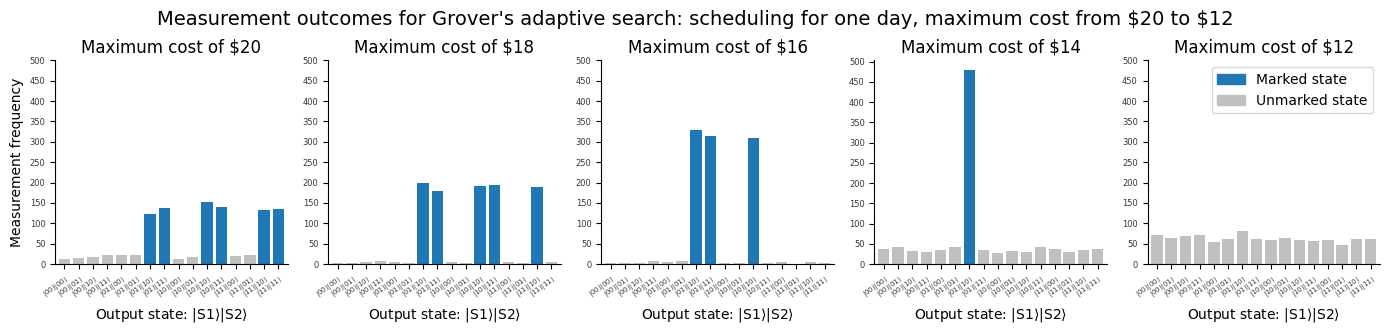

In [8]:
max_ytick = 50*(int(maximum_count/50)+1)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(14, 3.5), sharey=False)
axs[0].set_ylabel("Measurement frequency",size=10)
for i in range(len(costs)):
    sorteddict, barcolors = data[i]
    axs[i].bar(range(len(sorteddict)), list(sorteddict.values()), tick_label=list(sorteddict.keys()), color=barcolors)
    plt.setp(axs[i].get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor", size=5, color='#343837' )
    axs[i].set_title("Maximum cost of $" + str(costs[i]), size=12)
    axs[i].set_xlabel("Output state: |S1$\\rangle$|S2$\\rangle$",size=10)
    axs[i].spines[['right', 'top']].set_visible(False)
    axs[i].margins(x=0.016)

    axs[i].set_yticks(range(0,max_ytick+1,50), color='#343837')
    axs[i].set_yticklabels(range(0,max_ytick+1,50), color='#343837', fontsize=6)

custom_lines = [plt.Rectangle((0,0),1,1, color=markedcolor),
                plt.Rectangle((0,0),1,1, color=defaultcolor)]
fig.subplots_adjust(wspace=0, hspace=0)
axs[-1].legend(custom_lines, ["Marked state", "Unmarked state"], fontsize=10, loc='upper right') #  bbox_to_anchor=(1, 0.5)

fig.suptitle("Measurement outcomes for Grover's adaptive search: scheduling for one day, maximum cost from \$20 to \$12", y=0.94, size=14)
fig.tight_layout()
plt.show()

Uncomment to save the figure

In [9]:
# filename = "QISS_GAS_1day_decreasing_max_cost.eps"
# fig.savefig(filename, format='eps')